# Analysis notebook:

Manuscript: AF2χ: predicting protein side-chain rotamer distributions with AlphaFold2

Authors: Matteo Cagiada / F. Emil Thomasen

This notebook covers data and analysis for manuscript figures and tables:

- Fig S11


In [1]:
import pickle
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import os
import Bio 
import mdtraj as md

from scipy.stats import circmean
from scipy.spatial.distance import jensenshannon

In [14]:
from Bio.Data.IUPACData import protein_letters_1to3

In [2]:
Bio.__version__

'1.83'

In [3]:
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

In [4]:
def rot_pop_rebinned_to_three(input_distr):
    assert len(input_distr) == 36, "not correct length"

    return [np.sum(input_distr[0:12]),np.sum(input_distr[12:24]),np.sum(input_distr[24:36])]

In [5]:
def gaussian(x, a, mu, sigma):
    y = a * 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*(np.square(x-mu)/np.square(sigma)))
    return y

In [6]:
def plot_boxplot_with_points(*args, colors=None,labels=None, title=None,ylabel=r'$JS_{div}$'):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """
    
    # Create the figure and axis
    plt.figure(figsize=(18, 4))
    meanprops = {'color': 'red', 'linewidth': 20}
    # Plot the boxplot
    sns.boxplot(data=args, width=0.2, color='white',showmeans=True, meanprops=meanprops)

    for i, data in enumerate(args):
        # Add jitter to avoid points overlapping
        x = np.random.normal(i+0.3, 0.04, size=len(data))

        # Plot the raw data points
        if colors:
            for j, (x_val, y_val) in enumerate(zip(x, data)):
                plt.scatter(x_val, y_val, color=colors[j], alpha=0.7,edgecolor='w')
        else:
            plt.plot(x, data, 'r.', alpha=0.5)
    plt.ylim(-0.01,1)
    plt.ylabel(ylabel,fontsize=20)
    plt.grid(axis='y',alpha=0.2,zorder=-200)
    # Add labels if provided
    if labels:
        plt.xticks(range(len(args)), labels,fontsize=20)
    
    # Add title if provided
    if title:
        plt.title(title)

In [7]:
def plot_boxplot(*args, labels=None, title=None,box_color='#d55c00'):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """
    
    # Create the figure and axis
    plt.figure(figsize=(18, 4))
    meanprops = {'color': 'red', 'linewidth': 20}

    # Plot the boxplot
    sns.boxplot(data=args, width=0.2, color=box_color,showmeans=True)
    plt.ylim(-0.01,1)
    plt.ylabel(r'$JS_{div}$')
    # Add labels if provided
    if labels:
        plt.xticks(range(len(args)), labels)
    
    # Add title if provided
    if title:
        plt.title(title)

In [16]:
def interpolate_distribution(original_bins: np.ndarray, new_bin_count: int) -> np.ndarray:
    """
    Interpolates a given distribution into a new bin count while maintaining normalization.
    
    Parameters:
    original_bins (np.ndarray): Array of original bin values (must be normalized).
    new_bin_count (int): Number of bins in the new distribution.

    Returns:
    np.ndarray: Interpolated distribution with the same total probability (normalized to 1).
    """
    original_bin_count = len(original_bins)
    original_positions = np.linspace(0, 360, original_bin_count, endpoint=False)
    new_positions = np.linspace(0, 360, new_bin_count, endpoint=False)
    
    # Perform interpolation
    interpolated_values = np.interp(new_positions, original_positions, original_bins)
    
    # Normalize to maintain the total sum of 1
    interpolated_values /= interpolated_values.sum()
    
    return interpolated_values


## global var

In [17]:
dihedral_angles=[10*i for i in range(36)]

## UBQ

In [18]:
ubq_seq="MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG"

### load all dropout

In [19]:
with open('../data/gen_models_data/af_dropout/ubq_dropout_chis_merged.json') as json_in:
    all_chis_dropout=json.load(json_in)

### load seqdance

In [20]:
seqdance_chi1={}

np_data=np.load('../data/gen_models_data/seqdance/ubq_seqdance_chis_normalized.npy')

for idx,res in enumerate(ubq_seq):
    seqdance_chi1[(protein_letters_1to3[res]+str(idx+1)).upper()]=list(np_data[idx])

### load MDgen

In [21]:
# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/mdgen/traj/1ubi_A_2000.xtc", top="../data/gen_models_data/mdgen/traj/1ubi_A.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_mdgen = {}
chis_mdgen['chi1']={}
chis_mdgen['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_mdgen['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_mdgen['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load sam2

In [22]:
# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/asamt/ubq/ubq.traj.dcd", top="../data/gen_models_data/asamt/ubq/ubq.top.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_sam2 = {}
chis_sam2['chi1']={}
chis_sam2['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_sam2['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_sam2['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load bioemu

In [23]:
# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/bioemu/ubq/samples_sidechain_rec.xtc", top="../data/gen_models_data/bioemu/ubq/samples_sidechain_rec.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_bioemu = {}
chis_bioemu['chi1']={}
chis_bioemu['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_bioemu['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_bioemu['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load af2chis predicted

In [24]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_pops_fitted.json') as json_in:
    all_chis_fitted=json.load(json_in)

### load all pdb ensemble

In [25]:
with open('../data/struct_data/ubq__pdbs_chis_seqid99.json') as json_in:
    all_chis_pdb_ensemble=json.load(json_in)

### load structure

In [26]:
layer_chi=3
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

### chi1

In [27]:
chi_sel='chi1'

In [28]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

seqdance_distributions = seqdance_chi1

dropout_distributions = all_chis_dropout[chi_sel]

reweighting_ensemble_angles_distr=all_chis_fitted[chi_sel]

MDgen_angles_distr=chis_mdgen[chi_sel]

sam2_angles_distr=chis_sam2[chi_sel]

bioemu_angles_distr=chis_bioemu[chi_sel]

In [29]:
x=[i for i in range(5,360,10)]
x_range=[i for i in range(0,365,10)]
print(len(x_range),len(x))

37 36


In [30]:
x_seq=[i for i in range(15,360,30)]
x_seq_range=[i for i in range(0,365,30)]
print(len(x_seq_range),len(x_seq))

13 12


In [31]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [32]:
dropout_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in dropout_distributions[key]]
    
    dropout_ensemble_angles_distr[key]=np.histogram(degr_conv,bins=x_range)[0]/len(degr_conv)

In [33]:
mdgen_ensemble_angles_distr={}

for key in MDgen_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MDgen_angles_distr[key]]
    
    MDgen_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [34]:
sam2_ensemble_angles_distr={}

for key in sam2_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in sam2_angles_distr[key]]
    
    sam2_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [35]:
bioemu_ensemble_angles_distr={}

for key in bioemu_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in bioemu_angles_distr[key]]
    
    bioemu_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [36]:
seq_dance_ensemble_angles_distr=seqdance_distributions

In [37]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,0.25)

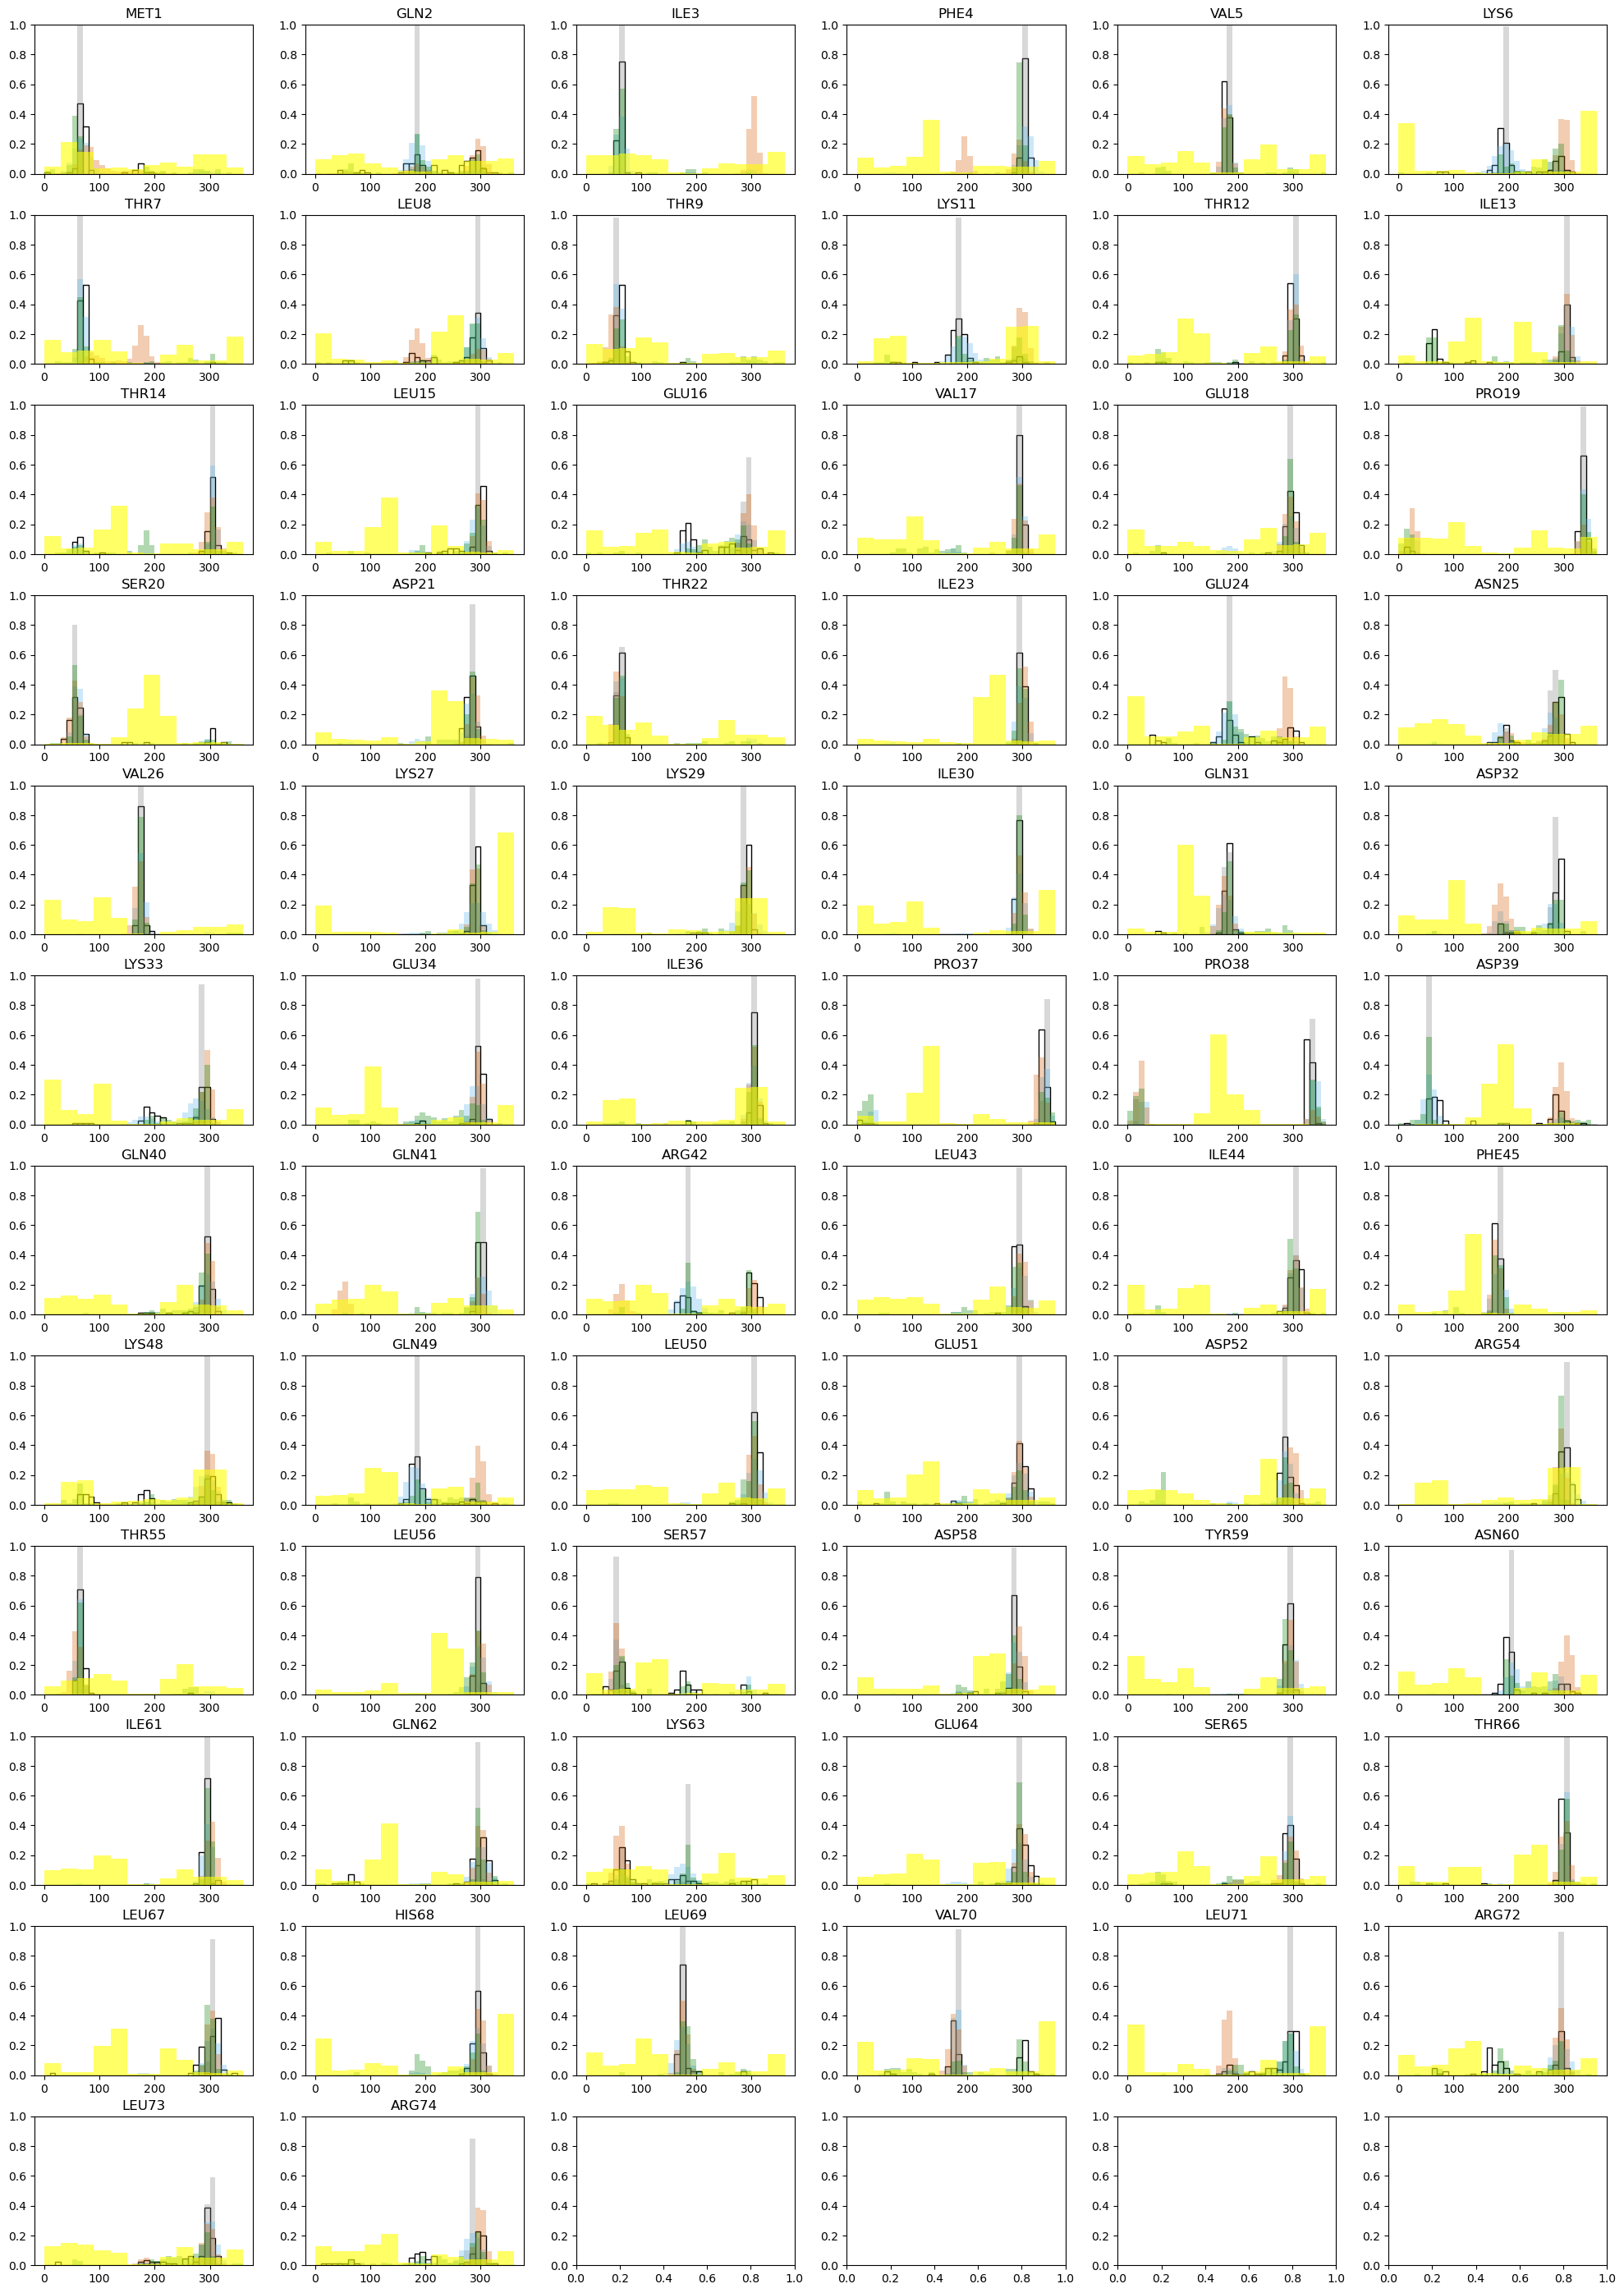

In [38]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(12,6,figsize=(20,28))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)

            axs[idx_ax].bar(x,dropout_ensemble_angles_distr[res],color='gray',width=10,alpha=0.3)

            axs[idx_ax].bar(x,reweighting_ensemble_angles_distr[res],color='#56b4e9',width=10,alpha=0.3)
            
            axs[idx_ax].bar(x,MDgen_angles_distr[res],color='#d55c00',width=10,alpha=0.3)
            axs[idx_ax].bar(x,bioemu_angles_distr[res],color='green',width=10,alpha=0.3)

            axs[idx_ax].bar(x_seq,seq_dance_ensemble_angles_distr[res],color='yellow',width=30,zorder=+10,alpha=0.6)

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/ubq_all_chi_rewei_vs_generated_ensemble.png',dpi=500)

In [39]:
js_dropout=[]
js_seqdance=[]
js_MDgen=[]
js_bioemu=[]
js_sam2=[]

js_re=[]
js_af2=[]

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_re.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_dropout.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_MDgen.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_bioemu.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_sam2.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_seqdance.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [40]:
is_fixed={}

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
                                     
js_re_fixed=[]
js_dropout_fixed=[]
js_seqdance_fixed=[]
js_MDgen_fixed=[]
js_bioemu_fixed=[]
js_af2_fixed=[]
js_sam2_fixed=[]

js_re_multi=[]
js_dropout_multi=[]
js_seqdance_multi=[]
js_MDgen_multi=[]
js_bioemu_multi=[]
js_af2_multi=[]
js_sam2_multi=[]

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        if is_fixed[res]:
            js_re_fixed.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_dropout_fixed.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_seqdance_fixed.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
            js_MDgen_fixed.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_bioemu_fixed.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_sam2_fixed.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_af2_fixed.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

        else:
            js_re_multi.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_dropout_multi.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_seqdance_multi.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
            js_MDgen_multi.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_bioemu_multi.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_sam2_multi.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_af2_multi.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))


In [41]:
print('All(tot: ',len(js_dropout))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std_dev',np.std(js_af2))
print('js_dropout - sum:',np.sum(js_dropout),' mean: ', np.mean(js_dropout),'std_dev',np.std(js_dropout))
print('js_seqdance - sum:',np.sum(js_seqdance),' mean: ', np.mean(js_seqdance),'std_dev',np.std(js_seqdance))
print('js_MDgen - sum:',np.sum(js_MDgen),' mean: ', np.mean(js_MDgen),'std_dev',np.std(js_MDgen))
print('js_bioemu - sum:',np.sum(js_bioemu),' mean: ', np.mean(js_bioemu),'std_dev',np.std(js_bioemu))
print('js_sam2 - sum:',np.sum(js_sam2),' mean: ', np.mean(js_sam2),'std_dev',np.std(js_sam2))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std_dev',np.std(js_re))


All(tot:  68
js_af2 - sum: 39.58809611152834  mean:  0.5821778839930638 std_dev 0.13767135609121617
js_dropout - sum: 33.267238577644974  mean:  0.48922409673007317 std_dev 0.13000605575358418
js_seqdance - sum: 49.7690577149597  mean:  0.7318979075729368 std_dev 0.06979214135582154
js_MDgen - sum: 27.450673491348798  mean:  0.4036863748727764 std_dev 0.16825045260555013
js_bioemu - sum: 26.69436433494939  mean:  0.39256418139631455 std_dev 0.09714998534720494
js_sam2 - sum: 26.498021238833086  mean:  0.389676782924016 std_dev 0.09206170225826611
js_re - sum: 23.373798270327974  mean:  0.34373232750482313 std_dev 0.08199944528723892


In [42]:
print('Fixed (tot: ',len(js_dropout_fixed))
print('js_af2 - sum:',np.sum(js_af2_fixed),' mean: ', np.mean(js_af2_fixed),'std_dev',np.std(js_af2_fixed))
print('js_dropout - sum:',np.sum(js_dropout_fixed),' mean: ', np.mean(js_dropout_fixed),'std_dev',np.std(js_dropout_fixed))
print('js_seqdance - sum:',np.sum(js_seqdance_fixed),' mean: ', np.mean(js_seqdance_fixed),'std_dev',np.std(js_seqdance_fixed))
print('js_MDgen - sum:',np.sum(js_MDgen_fixed),' mean: ', np.mean(js_MDgen_fixed),'std_dev',np.std(js_MDgen_fixed))
print('js_bioemu - sum:',np.sum(js_bioemu_fixed),' mean: ', np.mean(js_bioemu_fixed),'std_dev',np.std(js_bioemu_fixed))
print('js_sam2- sum:',np.sum(js_sam2_fixed),' mean: ', np.mean(js_sam2_fixed),'std_dev',np.std(js_sam2_fixed))
print('js_re - sum:',np.sum(js_re_fixed),' mean: ', np.mean(js_re_fixed),'std_dev',np.std(js_re_fixed))


Fixed (tot:  23
js_af2 - sum: 12.850326050983606  mean:  0.558709828303635 std_dev 0.1530694000553238
js_dropout - sum: 9.312470097685779  mean:  0.4048900042472078 std_dev 0.11565823157889399
js_seqdance - sum: 17.771193308500884  mean:  0.7726605786304732 std_dev 0.05189507627372376
js_MDgen - sum: 8.308161548560497  mean:  0.3612244151548042 std_dev 0.17068605583082275
js_bioemu - sum: 8.418990602391421  mean:  0.3660430696691922 std_dev 0.12315101435904573
js_sam2- sum: 8.936128875889098  mean:  0.3885273424299608 std_dev 0.09192271112272633
js_re - sum: 7.900690978686504  mean:  0.34350830342115235 std_dev 0.08920104101100922


In [43]:
print('Multi (tot: ',len(js_dropout_multi))
print('js_af2 - sum:',np.sum(js_af2_multi),' mean: ', np.mean(js_af2_multi),'std_dev',np.std(js_af2_multi))
print('js_dropout - sum:',np.sum(js_dropout_multi),' mean: ', np.mean(js_dropout_multi),'std_dev',np.std(js_dropout_multi))
print('js_seqdance- sum:',np.sum(js_seqdance_multi),' mean: ', np.mean(js_seqdance_multi),'std_dev',np.std(js_seqdance_multi))
print('js_bioemu - sum:',np.sum(js_bioemu_multi),' mean: ', np.mean(js_bioemu_multi),'std_dev',np.std(js_MDgen_multi))
print('js_MDgen- sum:',np.sum(js_MDgen_multi),' mean: ', np.mean(js_MDgen_multi),'std_dev',np.std(js_bioemu_multi))
print('js_sam2- sum:',np.sum(js_sam2_multi),' mean: ', np.mean(js_sam2_multi),'std_dev',np.std(js_sam2_multi))
print('js_re - sum:',np.sum(js_re_multi),' mean: ', np.mean(js_re_multi),'std_dev',np.std(js_re_multi))


Multi (tot:  45
js_af2 - sum: 26.737770060544744  mean:  0.5941726680121054 std_dev 0.12743575266537446
js_dropout - sum: 23.954768479959196  mean:  0.5323281884435377 std_dev 0.11493478681498212
js_seqdance- sum: 31.99786440645882  mean:  0.7110636534768626 std_dev 0.0685619230979807
js_bioemu - sum: 18.27537373255797  mean:  0.406119416279066 std_dev 0.16276895222629248
js_MDgen- sum: 19.1425119427883  mean:  0.42538915428418445 std_dev 0.07724767950717262
js_sam2- sum: 17.561892362943986  mean:  0.3902642747320886 std_dev 0.09212712318336787
js_re - sum: 15.473107291641465  mean:  0.34384682870314365 std_dev 0.0780622370068544


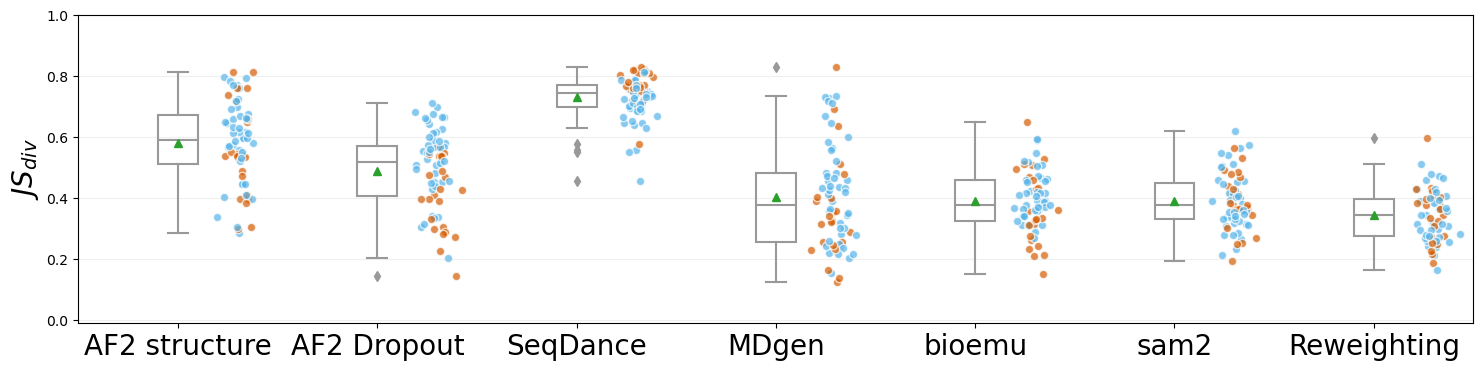

In [44]:
## Fig S11a

plot_boxplot_with_points(js_af2,js_dropout,js_seqdance,js_MDgen,js_bioemu,js_sam2,js_re,labels=['AF2 structure','AF2 Dropout','SeqDance','MDgen','bioemu','sam2','Reweighting'],colors=['#d55c00' if val else '#56b4e9' for val in list(is_fixed.values())])
plt.savefig('../figures/ubq_js_all_methods_comparison_boxplots_points.pdf')

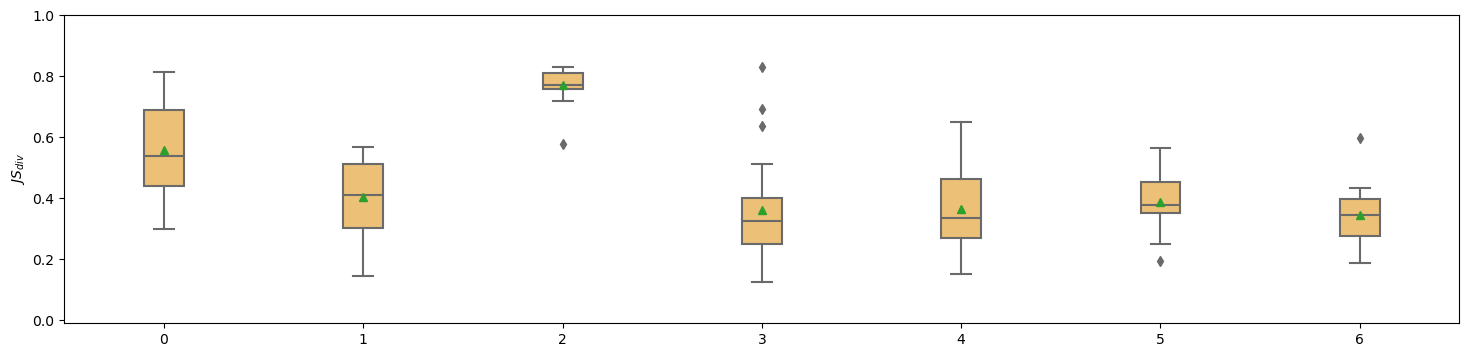

In [45]:
## Fig S11a

plot_boxplot(js_af2_fixed,js_dropout_fixed,js_seqdance_fixed,js_MDgen_fixed,js_bioemu_fixed,js_sam2_fixed,js_re_fixed,box_color='#ffc563')
plt.savefig('../figures/ubq_js_fixed_methods_comparison_boxplots_points.pdf')

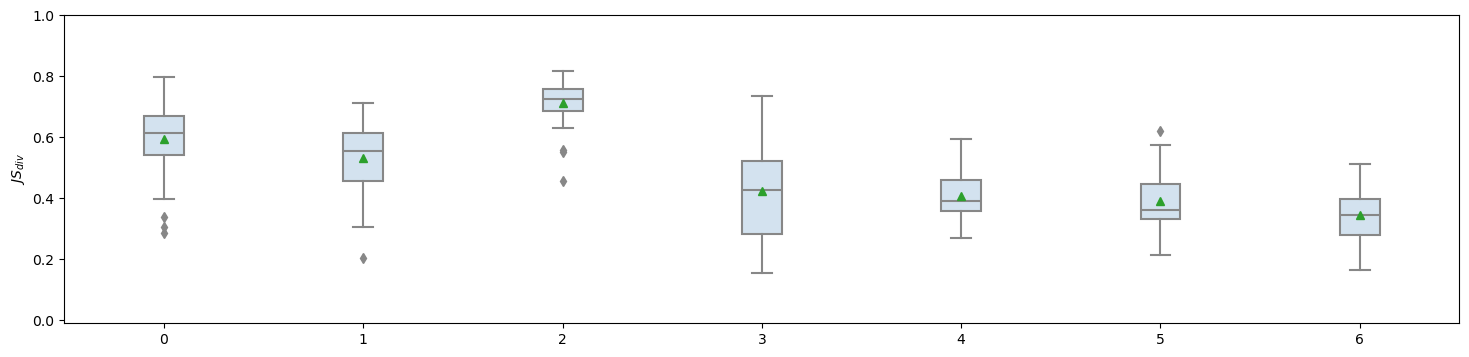

In [46]:
## Fig S11a

plot_boxplot(js_af2_multi,js_dropout_multi,js_seqdance_multi,js_MDgen_multi,js_bioemu_multi,js_sam2_multi,js_re_multi,box_color='#cfe2f3')
plt.savefig('../figures/ubq_js_multi_methods_comparison_boxplots_points.pdf')

# HEWL

In [47]:
hewl_seq="KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL"

### load all dropout

In [48]:
with open('../data/gen_models_data/af_dropout/hewl_dropout_chis_merged.json') as json_in:
    all_chis_dropout=json.load(json_in)

### load seqdance

In [49]:
seqdance_chi1={}

np_data=np.load('../data/gen_models_data/seqdance/hewl_seqdance_chis_normalized.npy')

for idx,res in enumerate(hewl_seq):
    seqdance_chi1[(protein_letters_1to3[res]+str(idx+1)).upper()]=list(np_data[idx])


### load MDgen

In [50]:

# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/mdgen/traj/6lyt_A_2000.xtc", top="../data/gen_models_data/mdgen/traj/6lyt_A.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_mdgen = {}
chis_mdgen['chi1']={}
chis_mdgen['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_mdgen['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_mdgen['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load bioemu

In [51]:

# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/bioemu/hewl/samples_sidechain_rec.xtc", top="../data/gen_models_data/bioemu/hewl/samples_sidechain_rec.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_bioemu = {}
chis_bioemu['chi1']={}
chis_bioemu['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_bioemu['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_bioemu['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load sam2

In [52]:

# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/asamt/hewl/hewl.traj.dcd", top="../data/gen_models_data/asamt/hewl/hewl.top.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_sam2 = {}
chis_sam2['chi1']={}
chis_sam2['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_sam2['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_sam2['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load af2chis predicted

In [53]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/output/6LYT_1_Chain_A_HEN_EGG_WHITE_LYSOZYME_Gallus_gallus__9031__rank_001_sc_pops_fitted.json') as json_in:
    all_chis_fitted=json.load(json_in)

### load all pdb ensemble

In [54]:
with open('../data/struct_data/hewl__pdbs_chis_seqid99.json') as json_in:
    all_chis_pdb_ensemble=json.load(json_in)

### load structure

In [55]:
layer_chi=3
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/output/6LYT_1_Chain_A_HEN_EGG_WHITE_LYSOZYME_Gallus_gallus__9031__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

## chi1

In [56]:
chi_sel='chi1'

In [57]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

seqdance_distributions = seqdance_chi1

dropout_distributions = all_chis_dropout[chi_sel]

reweighting_ensemble_angles_distr=all_chis_fitted[chi_sel]

MDgen_angles_distr=chis_mdgen[chi_sel]
sam2_angles_distr=chis_sam2[chi_sel]

bioemu_angles_distr=chis_bioemu[chi_sel]

In [58]:
x=[i for i in range(5,360,10)]
x_range=[i for i in range(0,365,10)]
print(len(x_range),len(x))

37 36


In [59]:
x_seq=[i for i in range(15,360,30)]
x_seq_range=[i for i in range(0,365,30)]
print(len(x_seq_range),len(x_seq))

13 12


In [60]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [61]:
dropout_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in dropout_distributions[key]]
    
    dropout_ensemble_angles_distr[key]=np.histogram(degr_conv,bins=x_range)[0]/len(degr_conv)

In [62]:
mdgen_ensemble_angles_distr={}

for key in MDgen_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MDgen_angles_distr[key]]
    
    MDgen_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [63]:
sam2_ensemble_angles_distr={}

for key in sam2_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in sam2_angles_distr[key]]
    
    sam2_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [64]:
bioemu_ensemble_angles_distr={}

for key in bioemu_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in bioemu_angles_distr[key]]
    
    bioemu_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [65]:
seq_dance_ensemble_angles_distr=seqdance_distributions

In [66]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,0.25)

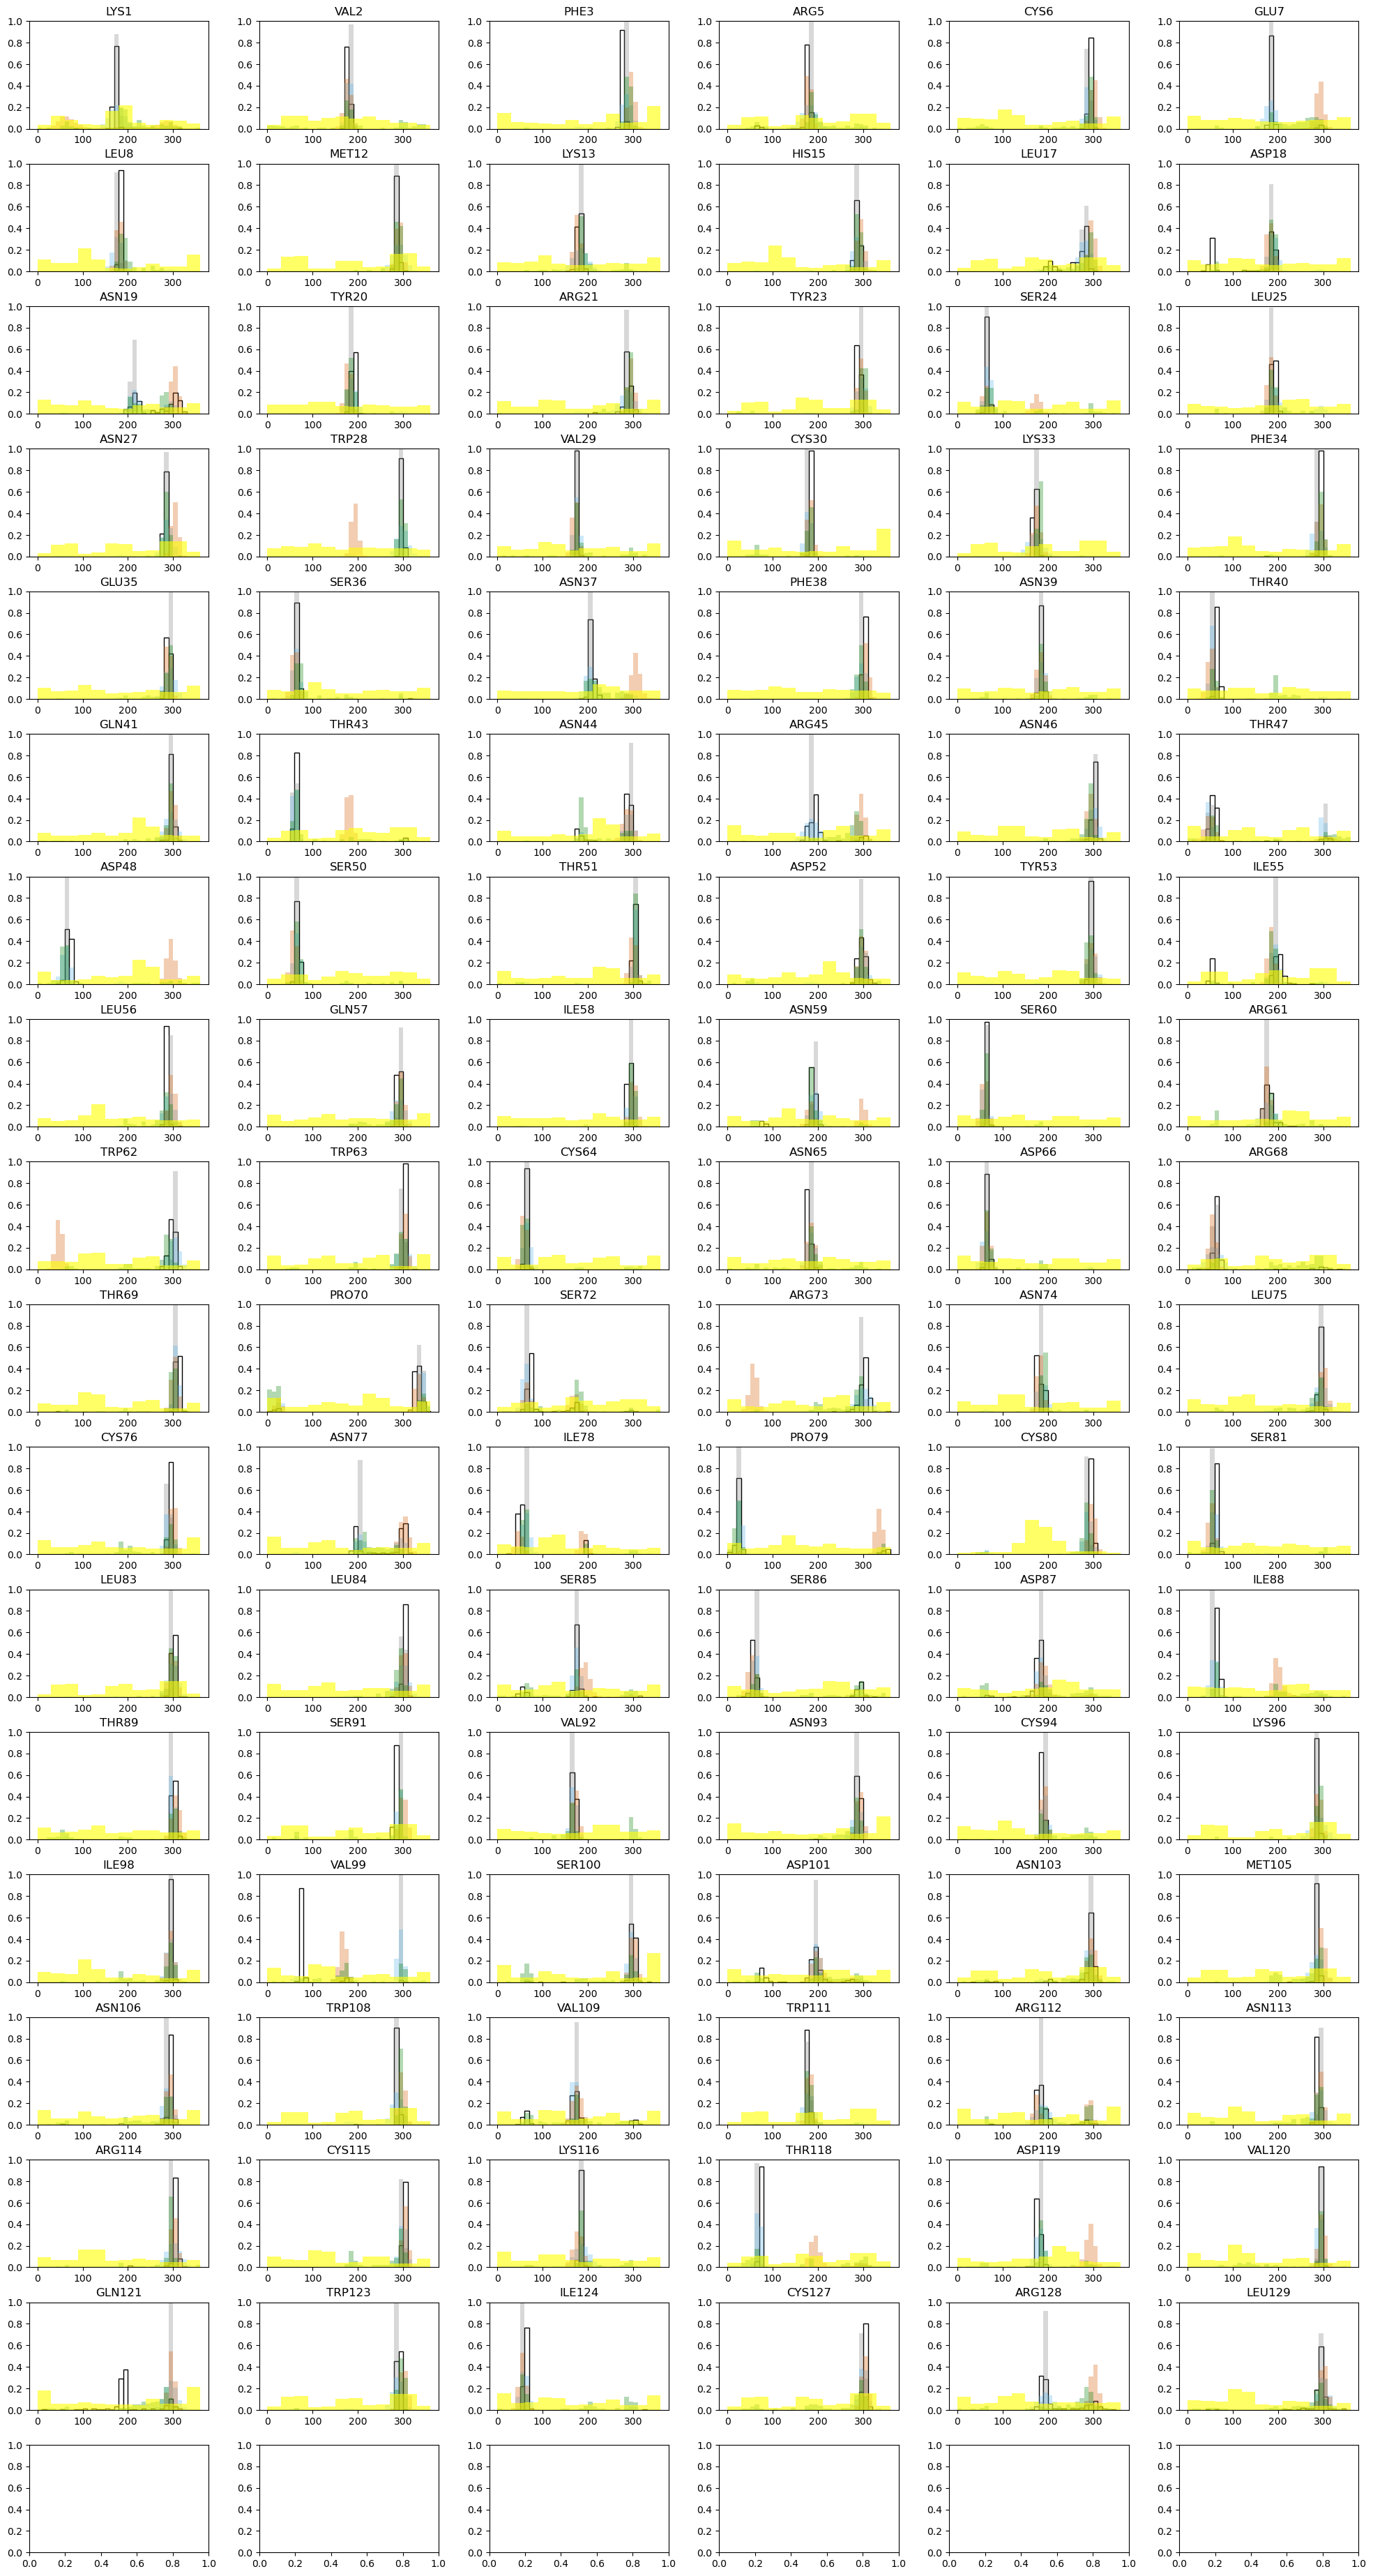

In [67]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(18,6,figsize=(20,37))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)

            axs[idx_ax].bar(x,dropout_ensemble_angles_distr[res],color='gray',width=10,alpha=0.3)

            axs[idx_ax].bar(x,reweighting_ensemble_angles_distr[res],color='#56b4e9',width=10,alpha=0.3)
            
            axs[idx_ax].bar(x,MDgen_angles_distr[res],color='#d55c00',width=10,alpha=0.3)

            axs[idx_ax].bar(x,bioemu_angles_distr[res],color='green',width=10,alpha=0.3)

            axs[idx_ax].bar(x_seq,seq_dance_ensemble_angles_distr[res],color='yellow',width=30,zorder=+10,alpha=0.6)

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/ubq_all_chi_rewei_vs_generated_ensemble.png',dpi=500)

In [68]:
js_dropout=[]
js_seqdance=[]
js_MDgen=[]
js_sam2=[]
js_bioemu=[]

js_re=[]
js_af2=[]

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_re.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_dropout.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_MDgen.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_sam2.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_bioemu.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_seqdance.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [69]:
is_fixed={}

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
                                     
js_re_fixed=[]
js_dropout_fixed=[]
js_seqdance_fixed=[]
js_MDgen_fixed=[]
js_sam2_fixed=[]
js_bioemu_fixed=[]
js_af2_fixed=[]

js_re_multi=[]
js_dropout_multi=[]
js_seqdance_multi=[]
js_MDgen_multi=[]
js_sam2_multi=[]
js_bioemu_multi=[]
js_af2_multi=[]

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        if is_fixed[res]:
            js_re_fixed.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_dropout_fixed.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_seqdance_fixed.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
            js_MDgen_fixed.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_sam2_fixed.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_bioemu_fixed.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_af2_fixed.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

        else:
            js_re_multi.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_dropout_multi.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_seqdance_multi.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
            js_MDgen_multi.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_sam2_multi.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_bioemu_multi.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_af2_multi.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))


In [70]:
print('All(tot: ',len(js_dropout))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std_dev',np.std(js_af2))
print('js_dropout - sum:',np.sum(js_dropout),' mean: ', np.mean(js_dropout),'std_dev',np.std(js_dropout))
print('js_seqdance - sum:',np.sum(js_seqdance),' mean: ', np.mean(js_seqdance),'std_dev',np.std(js_seqdance))
print('js_MDgen - sum:',np.sum(js_MDgen),' mean: ', np.mean(js_MDgen),'std_dev',np.std(js_MDgen))
print('js_sam2 - sum:',np.sum(js_sam2),' mean: ', np.mean(js_sam2),'std_dev',np.std(js_sam2))
print('js_bioemu - sum:',np.sum(js_bioemu),' mean: ', np.mean(js_bioemu),'std_dev',np.std(js_bioemu))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std_dev',np.std(js_re))


All(tot:  102
js_af2 - sum: 52.08058032298229  mean:  0.5105939247351206 std_dev 0.2255441551848437
js_dropout - sum: 46.410889705699766  mean:  0.45500872260489966 std_dev 0.20250884770402414
js_seqdance - sum: 75.57004725821406  mean:  0.7408828162570006 std_dev 0.046287312233954235
js_MDgen - sum: 47.913403671932684  mean:  0.46973925168561453 std_dev 0.18137841497804286
js_sam2 - sum: 50.356537675231344  mean:  0.49369154583560143 std_dev 0.12077882228569556
js_bioemu - sum: 48.97039361929374  mean:  0.48010189822836996 std_dev 0.12060608635224851
js_re - sum: 42.60961614381885  mean:  0.41774133474332203 std_dev 0.10198155702782463


In [71]:
print('Fixed (tot: ',len(js_dropout_fixed))
print('js_af2 - sum:',np.sum(js_af2_fixed),' mean: ', np.mean(js_af2_fixed),'std_dev',np.std(js_af2_fixed))
print('js_dropout - sum:',np.sum(js_dropout_fixed),' mean: ', np.mean(js_dropout_fixed),'std_dev',np.std(js_dropout_fixed))
print('js_seqdance - sum:',np.sum(js_seqdance_fixed),' mean: ', np.mean(js_seqdance_fixed),'std_dev',np.std(js_seqdance_fixed))
print('js_MDgen - sum:',np.sum(js_MDgen_fixed),' mean: ', np.mean(js_MDgen_fixed),'std_dev',np.std(js_MDgen_fixed))
print('js_sam2 - sum:',np.sum(js_sam2_fixed),' mean: ', np.mean(js_sam2_fixed),'std_dev',np.std(js_sam2_fixed))
print('js_bioemu - sum:',np.sum(js_bioemu_fixed),' mean: ', np.mean(js_bioemu_fixed),'std_dev',np.std(js_bioemu_fixed))
print('js_re - sum:',np.sum(js_re_fixed),' mean: ', np.mean(js_re_fixed),'std_dev',np.std(js_re_fixed))


Fixed (tot:  56
js_af2 - sum: 26.226831358007743  mean:  0.4683362742501383 std_dev 0.2489685377898997
js_dropout - sum: 23.201716383282506  mean:  0.4143163639871876 std_dev 0.21342653907882786
js_seqdance - sum: 42.898990025511935  mean:  0.7660533933127132 std_dev 0.02436735082348997
js_MDgen - sum: 25.401567205645247  mean:  0.45359941438652224 std_dev 0.18468688320417556
js_sam2 - sum: 27.584207987514656  mean:  0.4925751426341903 std_dev 0.12531408064485375
js_bioemu - sum: 25.374903071767633  mean:  0.45312326913870776 std_dev 0.12135204933852504
js_re - sum: 24.3558418673423  mean:  0.43492574763111247 std_dev 0.09350917434112137


In [72]:
print('Multi (tot: ',len(js_dropout_multi))
print('js_af2 - sum:',np.sum(js_af2_multi),' mean: ', np.mean(js_af2_multi),'std_dev',np.std(js_af2_multi))
print('js_dropout - sum:',np.sum(js_dropout_multi),' mean: ', np.mean(js_dropout_multi),'std_dev',np.std(js_dropout_multi))
print('js_seqdance- sum:',np.sum(js_seqdance_multi),' mean: ', np.mean(js_seqdance_multi),'std_dev',np.std(js_seqdance_multi))
print('js_MDgen- sum:',np.sum(js_MDgen_multi),' mean: ', np.mean(js_MDgen_multi),'std_dev',np.std(js_MDgen_multi))
print('js_sam2- sum:',np.sum(js_sam2_multi),' mean: ', np.mean(js_sam2_multi),'std_dev',np.std(js_sam2_multi))
print('js_bioemu- sum:',np.sum(js_bioemu_multi),' mean: ', np.mean(js_bioemu_multi),'std_dev',np.std(js_bioemu_multi))
print('js_re - sum:',np.sum(js_re_multi),' mean: ', np.mean(js_re_multi),'std_dev',np.std(js_re_multi))


Multi (tot:  46
js_af2 - sum: 25.853748964974553  mean:  0.5620380209777077 std_dev 0.180328191822367
js_dropout - sum: 23.209173322417264  mean:  0.5045472461395057 std_dev 0.17610135956961828
js_seqdance- sum: 32.67105723270213  mean:  0.7102403746239594 std_dev 0.0481424950584424
js_MDgen- sum: 22.511836466287438  mean:  0.4893877492671182 std_dev 0.17527276183900561
js_sam2- sum: 22.77232968771668  mean:  0.49505064538514526 std_dev 0.11500189232299202
js_bioemu- sum: 23.59549054752611  mean:  0.5129454466853502 std_dev 0.11118150167157381
js_re - sum: 18.253774276476555  mean:  0.3968211799234034 std_dev 0.10779339496881343


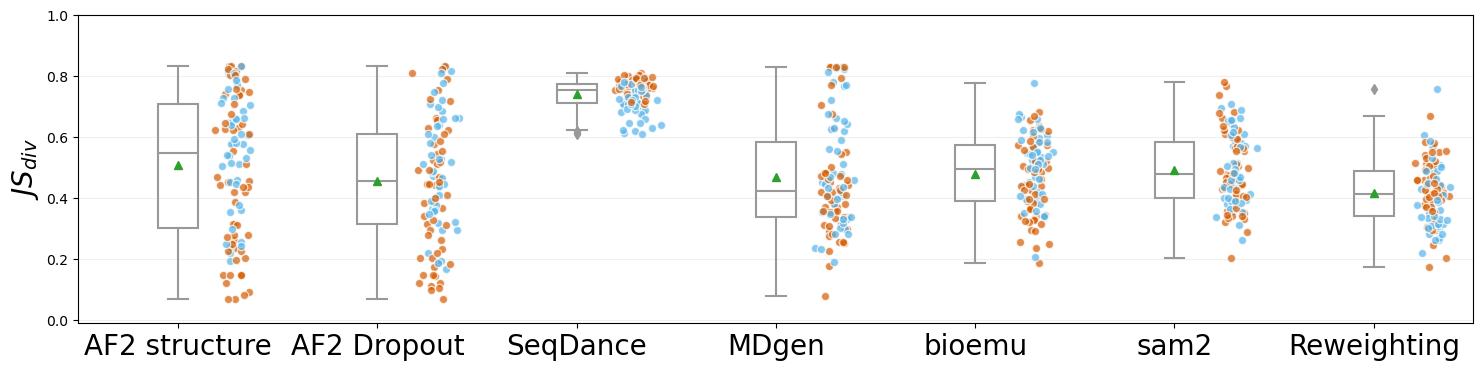

In [73]:
## Fig S11b


plot_boxplot_with_points(js_af2,js_dropout,js_seqdance,js_MDgen,js_bioemu,js_sam2,js_re,labels=['AF2 structure','AF2 Dropout','SeqDance','MDgen','bioemu','sam2','Reweighting'],colors=['#d55c00' if val else '#56b4e9' for val in list(is_fixed.values())])
plt.savefig('../figures/hewl_js_methods_comparison_boxplots_points.pdf')

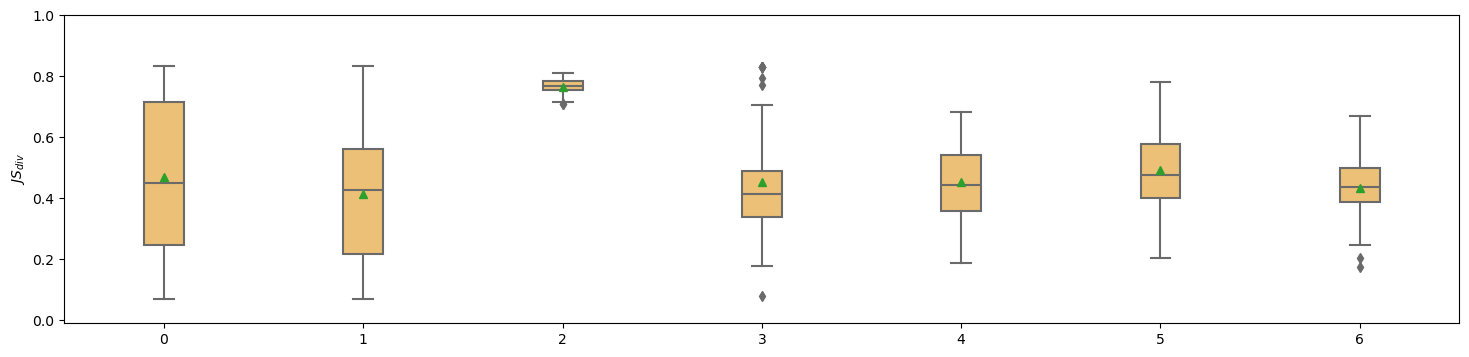

In [74]:
## Fig S11a

plot_boxplot(js_af2_fixed,js_dropout_fixed,js_seqdance_fixed,js_MDgen_fixed,js_bioemu_fixed,js_sam2_fixed,js_re_fixed,box_color='#ffc563')
plt.savefig('../figures/hewl_js_fixed_methods_comparison_boxplots_points.pdf')

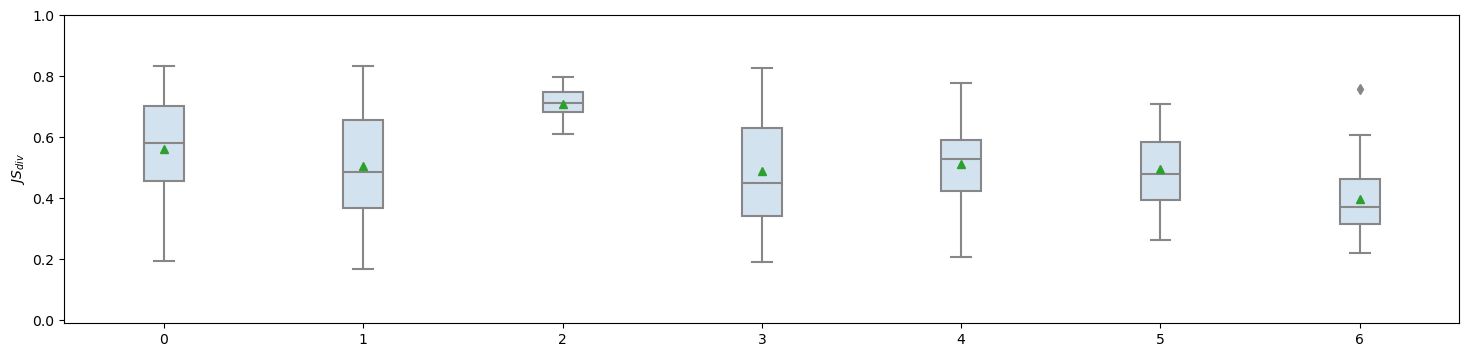

In [75]:
## Fig S11a

plot_boxplot(js_af2_multi,js_dropout_multi,js_seqdance_multi,js_MDgen_multi,js_bioemu_multi,js_sam2_multi,js_re_multi,box_color='#cfe2f3')
plt.savefig('../figures/hewl_js_multi_methods_comparison_boxplots_points.pdf')

# BPTI

In [76]:
btpi_seq='RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCMRTCGGA'

### load all dropout

In [77]:
with open('../data/gen_models_data/af_dropout/btpi_dropout_chis_merged.json') as json_in:
    all_chis_dropout=json.load(json_in)

### load seqdance

In [78]:
seqdance_chi1={}

np_data=np.load('../data/gen_models_data/seqdance/btpi_seqdance_chis_normalized.npy')

for idx,res in enumerate(btpi_seq):
    seqdance_chi1[(protein_letters_1to3[res]+str(idx+1)).upper()]=list(np_data[idx])


### load MDgen

In [79]:
# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/mdgen/traj/5pti_A_2000.xtc", top="../data/gen_models_data/mdgen/traj/5pti_A.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_mdgen = {}
chis_mdgen['chi1']={}
chis_mdgen['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_mdgen['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_mdgen['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load bioemu

In [80]:
# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/bioemu/bpti/samples_sidechain_rec.xtc", top="../data/gen_models_data/bioemu/bpti/samples_sidechain_rec.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_bioemu = {}
chis_bioemu['chi1']={}
chis_bioemu['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_bioemu['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_bioemu['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load sam2

In [81]:
# Load the trajectory and topology
trajectory = md.load("../data/gen_models_data/asamt/bpti/bpti.traj.dcd", top="../data/gen_models_data/asamt/bpti/bpti.top.pdb")
topology = trajectory.topology
# Compute chi1 and chi2 dihedral angles
chi1_indices, chi1_angles = md.compute_chi1(trajectory, periodic=True)
chi2_indices, chi2_angles = md.compute_chi2(trajectory, periodic=True)

# Map chi1
chis_sam2 = {}
chis_sam2['chi1']={}
chis_sam2['chi2']={}

for idx,indices in enumerate(chi1_indices):
    residue = topology.atom(indices[1]).residue
    chis_sam2['chi1'][residue.name + str(int(residue.index)+1)]= chi1_angles[:,idx]

# Map chi2
for idx,indices in enumerate(chi2_indices):
    residue = topology.atom(indices[1]).residue
    chis_sam2['chi2'][residue.name + str(int(residue.index)+1)]= chi2_angles[:,idx]

### load all pred

In [82]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/BPTI/output/5PTI_1_Chain_A_TRYPSIN_INHIBITOR_Bos_taurus__9913__rank_001_sc_pops_fitted.json') as json_in:
    all_chis_fitted=json.load(json_in)

### load all pdb ensemble

In [83]:
with open('../data/struct_data/btpi__pdbs_chis_seqid99.json') as json_in:
    all_chis_pdb_ensemble=json.load(json_in)

### load structure

In [84]:
layer_chi=3
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/BPTI/output/5PTI_1_Chain_A_TRYPSIN_INHIBITOR_Bos_taurus__9913__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

## chi1

In [85]:
chi_sel='chi1'

In [86]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

seqdance_distributions = seqdance_chi1

dropout_distributions = all_chis_dropout[chi_sel]

reweighting_ensemble_angles_distr=all_chis_fitted[chi_sel]

MDgen_angles_distr=chis_mdgen[chi_sel]

bioemu_angles_distr=chis_bioemu[chi_sel]

sam2_angles_distr=chis_sam2[chi_sel]



In [87]:
x=[i for i in range(5,360,10)]
x_range=[i for i in range(0,365,10)]
print(len(x_range),len(x))

37 36


In [88]:
x_seq=[i for i in range(15,360,30)]
x_seq_range=[i for i in range(0,365,30)]
print(len(x_seq_range),len(x_seq))

13 12


In [89]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [90]:
dropout_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in dropout_distributions[key]]
    
    dropout_ensemble_angles_distr[key]=np.histogram(degr_conv,bins=x_range)[0]/len(degr_conv)

In [91]:
MDgen_ensemble_angles_distr={}

for key in MDgen_angles_distr.keys():
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MDgen_angles_distr[key]]
    
    MDgen_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [92]:
bioemu_ensemble_angles_distr={}

for key in bioemu_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in bioemu_angles_distr[key]]
    
    bioemu_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [93]:
sam2_ensemble_angles_distr={}

for key in sam2_angles_distr.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in sam2_angles_distr[key]]
    
    sam2_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [94]:
seq_dance_ensemble_angles_distr=seqdance_distributions

In [95]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,0.25)

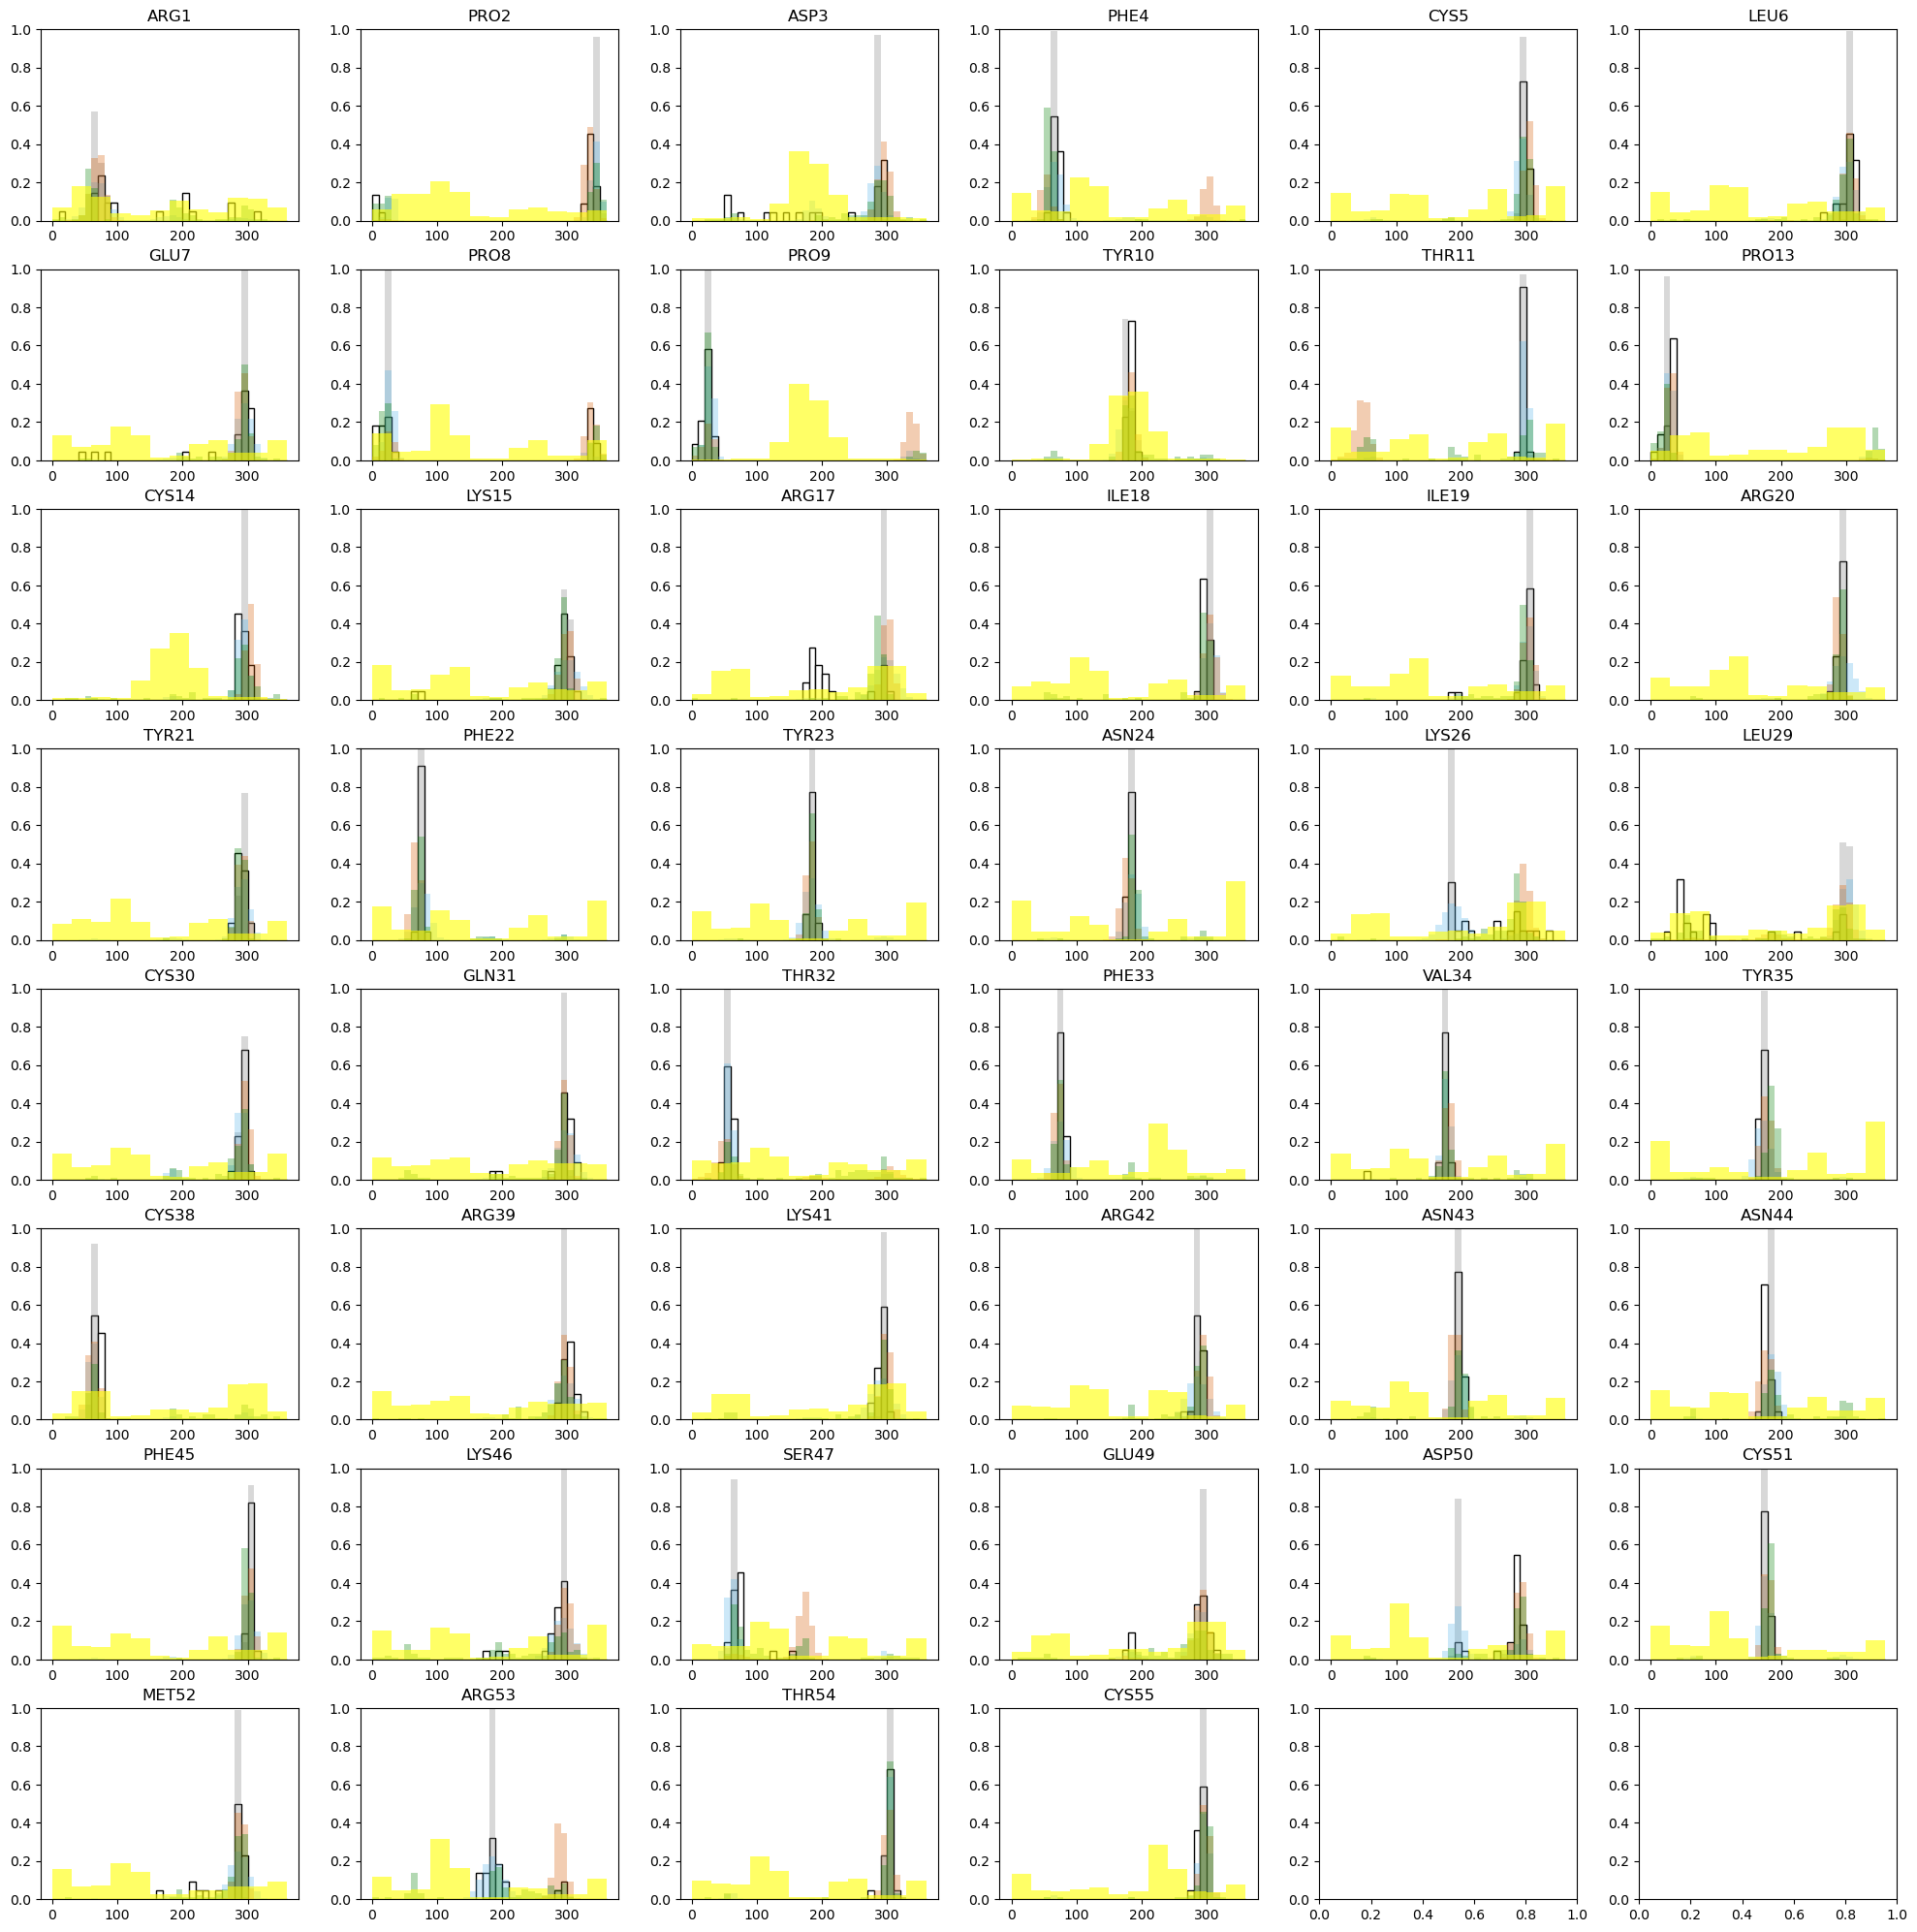

In [96]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(8,6,figsize=(20,20))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)

            axs[idx_ax].bar(x,dropout_ensemble_angles_distr[res],color='gray',width=10,alpha=0.3)

            axs[idx_ax].bar(x,reweighting_ensemble_angles_distr[res],color='#56b4e9',width=10,alpha=0.3)
            
            axs[idx_ax].bar(x,MDgen_angles_distr[res],color='#d55c00',width=10,alpha=0.3)
            axs[idx_ax].bar(x,bioemu_angles_distr[res],color='green',width=10,alpha=0.3)

            axs[idx_ax].bar(x_seq,seq_dance_ensemble_angles_distr[res],color='yellow',width=30,zorder=+10,alpha=0.6)

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/ubq_all_chi_rewei_vs_generated_ensemble.png',dpi=500)

In [97]:
js_dropout=[]
js_seqdance=[]
js_MDgen=[]
js_bioemu=[]
js_sam2=[]

js_re=[]
js_af2=[]

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_re.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_dropout.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_MDgen.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_bioemu.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_sam2.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_seqdance.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [98]:
is_fixed={}

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
                                     
js_re_fixed=[]
js_dropout_fixed=[]
js_seqdance_fixed=[]
js_MDgen_fixed=[]
js_bioemu_fixed=[]
js_sam2_fixed=[]
js_af2_fixed=[]

js_re_multi=[]
js_dropout_multi=[]
js_seqdance_multi=[]
js_MDgen_multi=[]
js_bioemu_multi=[]
js_sam2_multi=[]
js_af2_multi=[]

for idx,res in enumerate(reweighting_ensemble_angles_distr.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        if is_fixed[res]:
            js_re_fixed.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_dropout_fixed.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_seqdance_fixed.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
            js_MDgen_fixed.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_bioemu_fixed.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_sam2_fixed.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_af2_fixed.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

        else:
            js_re_multi.append(jensenshannon(reweighting_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_dropout_multi.append(jensenshannon(dropout_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_seqdance_multi.append(jensenshannon(interpolate_distribution(np.array(seq_dance_ensemble_angles_distr[res]),36),pdb_ensemble_angles_distr[res]))
            js_MDgen_multi.append(jensenshannon(MDgen_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_bioemu_multi.append(jensenshannon(bioemu_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_sam2_multi.append(jensenshannon(sam2_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_af2_multi.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))


In [99]:
print('All(tot: ',len(js_dropout))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std_dev',np.std(js_af2))
print('js_dropout - sum:',np.sum(js_dropout),' mean: ', np.mean(js_dropout),'std_dev',np.std(js_dropout))
print('js_seqdance - sum:',np.sum(js_seqdance),' mean: ', np.mean(js_seqdance),'std_dev',np.std(js_seqdance))
print('js_MDgen - sum:',np.sum(js_MDgen),' mean: ', np.mean(js_MDgen),'std_dev',np.std(js_MDgen))
print('js_bioemu - sum:',np.sum(js_bioemu),' mean: ', np.mean(js_bioemu),'std_dev',np.std(js_bioemu))
print('js_sam2 - sum:',np.sum(js_sam2),' mean: ', np.mean(js_sam2),'std_dev',np.std(js_sam2))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std_dev',np.std(js_re))


All(tot:  46
js_af2 - sum: 26.778802306330324  mean:  0.5821478762245722 std_dev 0.16312058046414138
js_dropout - sum: 20.174334758517023  mean:  0.4385724947503701 std_dev 0.14907829687256197
js_seqdance - sum: 34.03535109447369  mean:  0.7398989368363845 std_dev 0.06897003805542988
js_MDgen - sum: 18.54855672911234  mean:  0.40322949411113784 std_dev 0.1551261072647579
js_bioemu - sum: 19.41592330338155  mean:  0.4220852892039467 std_dev 0.12753410127280704
js_sam2 - sum: 22.363932799987516  mean:  0.48617245217364163 std_dev 0.12413690088643096
js_re - sum: 18.223693920310954  mean:  0.39616725913719464 std_dev 0.10172658285972754


In [100]:
print('Fixed (tot: ',len(js_dropout_fixed))
print('js_af2 - sum:',np.sum(js_af2_fixed),' mean: ', np.mean(js_af2_fixed),'std_dev',np.std(js_af2_fixed))
print('js_dropout - sum:',np.sum(js_dropout_fixed),' mean: ', np.mean(js_dropout_fixed),'std_dev',np.std(js_dropout_fixed))
print('js_seqdance - sum:',np.sum(js_seqdance_fixed),' mean: ', np.mean(js_seqdance_fixed),'std_dev',np.std(js_seqdance_fixed))
print('js_MDgen - sum:',np.sum(js_MDgen_fixed),' mean: ', np.mean(js_MDgen_fixed),'std_dev',np.std(js_MDgen_fixed))
print('js_bioemu - sum:',np.sum(js_bioemu_fixed),' mean: ', np.mean(js_bioemu_fixed),'std_dev',np.std(js_bioemu_fixed))
print('js_sam2 - sum:',np.sum(js_sam2_fixed),' mean: ', np.mean(js_sam2_fixed),'std_dev',np.std(js_sam2_fixed))
print('js_re - sum:',np.sum(js_re_fixed),' mean: ', np.mean(js_re_fixed),'std_dev',np.std(js_re_fixed))


Fixed (tot:  28
js_af2 - sum: 15.41053487928214  mean:  0.5503762456886478 std_dev 0.18523921028242787
js_dropout - sum: 10.500965268131745  mean:  0.375034473861848 std_dev 0.13259678817066234
js_seqdance - sum: 21.555553332537443  mean:  0.7698411904477658 std_dev 0.05102184299340912
js_MDgen - sum: 10.383659831268766  mean:  0.3708449939738845 std_dev 0.15135861724227345
js_bioemu - sum: 11.165735225033174  mean:  0.3987762580368991 std_dev 0.1338373263281548
js_sam2 - sum: 13.57239086923981  mean:  0.4847282453299932 std_dev 0.14009729453029968
js_re - sum: 10.42753748999722  mean:  0.37241205321418647 std_dev 0.08329997223085137


In [101]:
print('Multi (tot: ',len(js_dropout_multi))
print('js_af2 - sum:',np.sum(js_af2_multi),' mean: ', np.mean(js_af2_multi),'std_dev',np.std(js_af2_multi))
print('js_dropout - sum:',np.sum(js_dropout_multi),' mean: ', np.mean(js_dropout_multi),'std_dev',np.std(js_dropout_multi))
print('js_seqdance- sum:',np.sum(js_seqdance_multi),' mean: ', np.mean(js_seqdance_multi),'std_dev',np.std(js_seqdance_multi))
print('js_MDgen- sum:',np.sum(js_MDgen_multi),' mean: ', np.mean(js_MDgen_multi),'std_dev',np.std(js_MDgen_multi))
print('js_bioemu- sum:',np.sum(js_bioemu_multi),' mean: ', np.mean(js_bioemu_multi),'std_dev',np.std(js_bioemu_multi))
print('js_sam2- sum:',np.sum(js_sam2_multi),' mean: ', np.mean(js_sam2_multi),'std_dev',np.std(js_sam2_multi))
print('js_re - sum:',np.sum(js_re_multi),' mean: ', np.mean(js_re_multi),'std_dev',np.std(js_re_multi))


Multi (tot:  18
js_af2 - sum: 11.368267427048185  mean:  0.631570412613788 std_dev 0.10300277307064756
js_dropout - sum: 9.67336949038528  mean:  0.5374094161325156 std_dev 0.11574652280189247
js_seqdance- sum: 12.47979776193624  mean:  0.6933220978853467 std_dev 0.06740142258851474
js_MDgen- sum: 8.164896897843573  mean:  0.45360538321353183 std_dev 0.14727914639483672
js_bioemu- sum: 8.25018807834838  mean:  0.45834378213046556 std_dev 0.10743540901464817
js_sam2- sum: 8.791541930747707  mean:  0.4884189961526504 std_dev 0.09402905208647712
js_re - sum: 7.796156430313735  mean:  0.43311980168409636 std_dev 0.11579517358570601


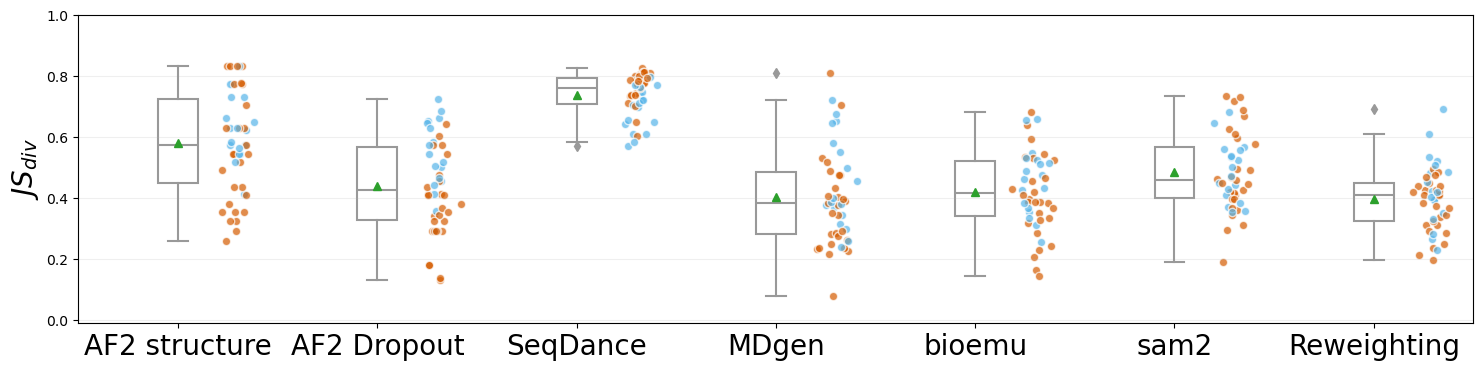

In [102]:
#Fig S11c

plot_boxplot_with_points(js_af2,js_dropout,js_seqdance,js_MDgen,js_bioemu,js_sam2,js_re,labels=['AF2 structure','AF2 Dropout','SeqDance','MDgen','bioemu','sam2','Reweighting'],colors=['#d55c00' if val else '#56b4e9' for val in list(is_fixed.values())])
plt.savefig('../figures/bpti_js_methods_comparison_boxplots_points.pdf')

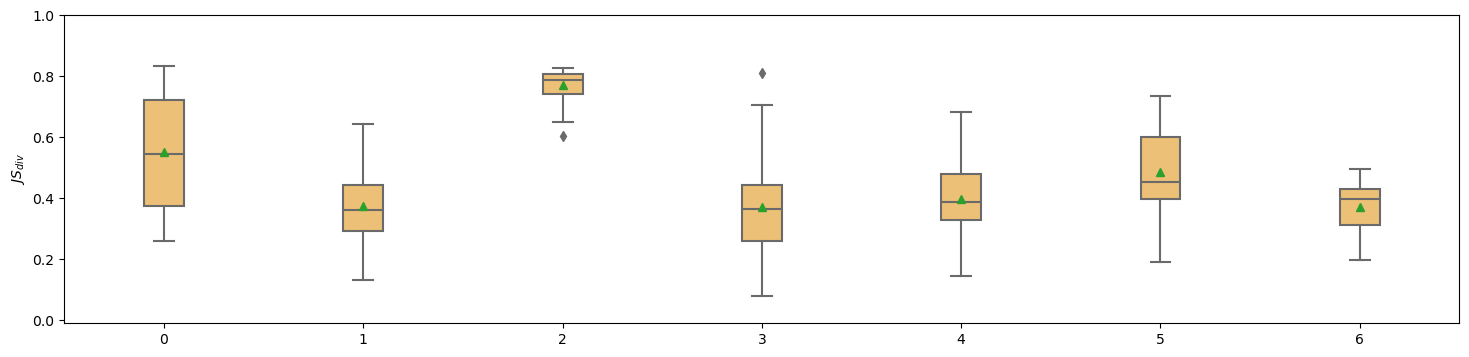

In [103]:
#Fig S11c

plot_boxplot(js_af2_fixed,js_dropout_fixed,js_seqdance_fixed,js_MDgen_fixed,js_bioemu_fixed,js_sam2_fixed,js_re_fixed,box_color='#ffc563')
plt.savefig('../figures/bpti_js_fixed_methods_comparison_boxplots_points.pdf')

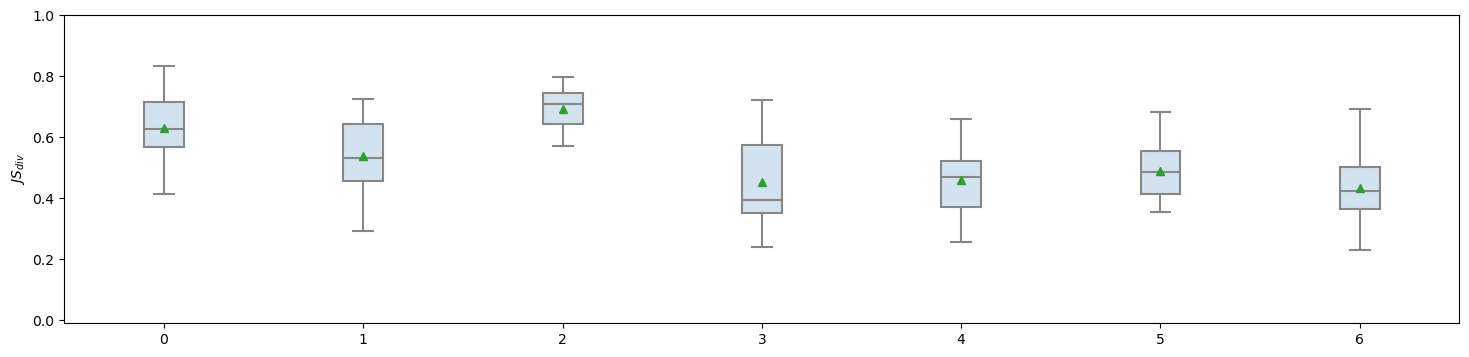

In [104]:
#Fig S11c

plot_boxplot(js_af2_multi,js_dropout_multi,js_seqdance_multi,js_MDgen_multi,js_bioemu_multi,js_sam2_multi,js_re_multi,box_color='#cfe2f3')
plt.savefig('../figures/bpti_js_multi_methods_comparison_boxplots_points.pdf')